<a href="https://colab.research.google.com/github/iptishadugtal/SENTIMENT-POLARITY-DETECTION-AND-TOPIC-MODELLING/blob/main/Svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
import os
import pickle

from nltk.corpus import stopwords
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig
import tensorflow as tf
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
train_dataset = '/content/train.csv'
test_dataset = '/content/test.csv'

In [ ]:
train_df = pd.read_csv(train_dataset, encoding='ISO-8859-1')
test_df = pd.read_csv(test_dataset, encoding='ISO-8859-1')

In [ ]:
train_df.isnull().sum()

,0
textID,0
text,1
selected_text,1
sentiment,0
Time of Tweet,0
Age of User,0
Country,0
Population -2020,0
Land Area (Km²),0
Density (P/Km²),0


In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
df = pd.concat([train_df, test_df])

In [ ]:
def remove_unnecessary_characters(text):
    text = re.sub(r'<.*?>', '', str(text))
    text = re.sub(r'[^a-zA-Z0-9\s]', '', str(text))
    text = re.sub(r'\s+', ' ', str(text)).strip()
    return text

In [ ]:
df['clean_text'] = df['text'].apply(remove_unnecessary_characters)

In [ ]:
from nltk.tokenize import word_tokenize
def tokenize_text(text):
    try:
        text = str(text)
        tokens = word_tokenize(text)
        return tokens
    except Exception as e:
        print(f"Error tokenizing text: {e}")
        return []
df['tokens'] = df['text'].apply(tokenize_text)

In [ ]:
def normalize_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
    else:
        text = str(text)
    return text

df['normalized_text'] = df['clean_text'].apply(normalize_text)

In [ ]:
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    if isinstance(text, str):
        words = text.split()
        filtered_words = [word for word in words if word.lower() not in stop_words]
        filtered_text = ' '.join(filtered_words)
    else:
        filtered_text = ''
    return filtered_text

df['text_without_stopwords'] = df['normalized_text'].apply(remove_stopwords)

In [ ]:
df.dropna(inplace=True)

In [ ]:
from nltk.stem import LancasterStemmer
from string import punctuation
stuff_to_be_removed = list(stopwords.words('english')) + list(punctuation)
stemmer = LancasterStemmer()
corpus = df['text'].tolist()
print(len(corpus))
print(corpus[10])

27480
 as much as i love to be hopeful, i reckon the chances are minimal =P i`m never gonna get my cake and stuff


In [ ]:
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

<ipython-input-36-f6cedce9129f>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=word_freq_df, palette='viridis')


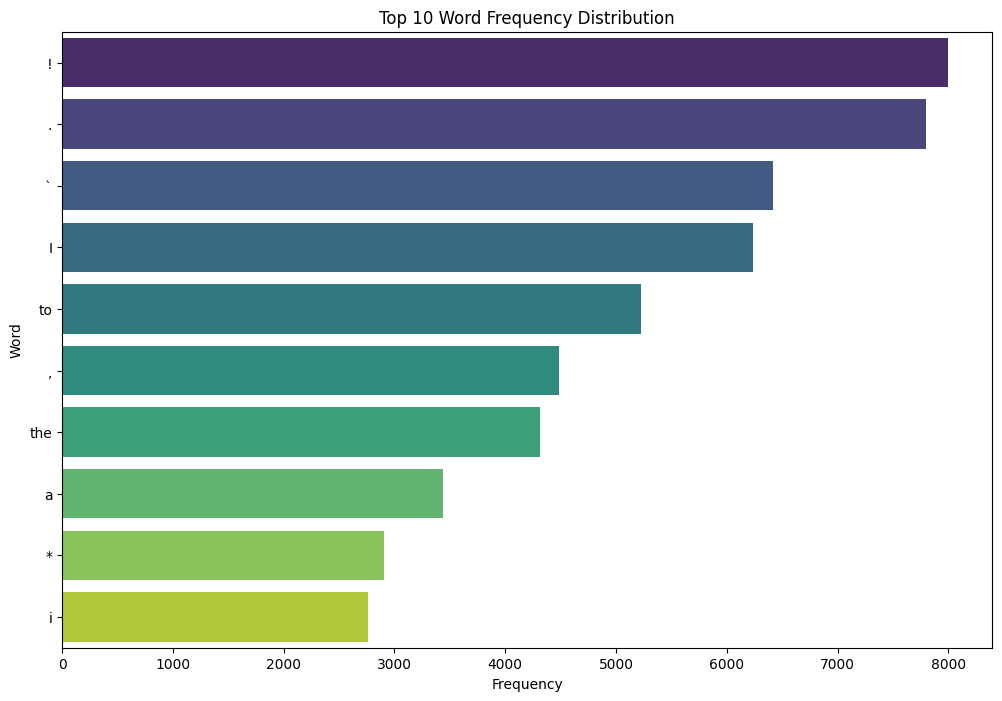

In [ ]:
all_words = word_tokenize(' '.join(df['selected_text']))
word_freq = FreqDist(all_words)

word_freq_df = pd.DataFrame(word_freq.most_common(10), columns=['Word', 'Frequency'])

plt.figure(figsize=(12, 8))
sns.barplot(x='Frequency', y='Word', data=word_freq_df, palette='viridis')

plt.title('Top 10 Word Frequency Distribution')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

In [ ]:
final_corpus = df['text'].astype(str).tolist()
data_eda = pd.DataFrame()
data_eda['text'] = final_corpus
data_eda['sentiment'] = df["sentiment"].values
data_eda.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [ ]:
df['Time of Tweet'] = df['Time of Tweet'].astype('category').cat.codes
df['Country'] = df['Country'].astype('category').cat.codes
df['Age of User']=df['Age of User'].replace({'0-20':18,'21-30':25,'31-45':38,'46-60':53,'60-70':65,'70-100':80})

<ipython-input-38-90b34bbc44bd>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Age of User']=df['Age of User'].replace({'0-20':18,'21-30':25,'31-45':38,'46-60':53,'60-70':65,'70-100':80})


In [ ]:
df=df.drop(columns=['textID','Time of Tweet', 'Age of User', 'Country', 'Population -2020', 'Land Area (Km²)', 'Density (P/Km²)'])

In [ ]:
import string
def wp(text):
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text
df['selected_text'] = df["selected_text"].apply(wp)

In [ ]:
df_neutral = df[df['sentiment'] == 'neutral']
df_positive = df[df['sentiment'] == 'positive']
df_negative = df[df['sentiment'] == 'negative']

# Upsampling minority classes
df_positive_upsampled = resample(df_positive, replace=True, n_samples=len(df_neutral), random_state=123)
df_negative_upsampled = resample(df_negative, replace=True, n_samples=len(df_neutral), random_state=123)

# Combining the dataframes
df_balanced = pd.concat([df_neutral, df_positive_upsampled, df_negative_upsampled])
print(df_balanced['sentiment'].value_counts())

label_mapping = {'neutral': 0, 'positive': 1, 'negative': 2}
df_balanced['label'] = df_balanced['sentiment'].map(label_mapping)

sentiment
neutral     11117
positive    11117
negative    11117
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split
X=df['selected_text']
y= df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(df_balanced['text_without_stopwords'], df_balanced['label'], test_size=0.2, random_state=42)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorizing the text data using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
score_baseline = df['sentiment'].value_counts(normalize=True).max()
score_baseline

0.40454876273653567

In [ ]:
from sklearn.svm import SVC
svm = SVC(kernel='linear', probability=True)
svm.fit(X_train_tfidf, y_train)

SVC(kernel='linear', probability=True)

In [ ]:
y_pred = svm.predict(X_test_tfidf)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'F1 Score: {f1_score(y_test, y_pred, average="weighted")}')

Accuracy: 0.7393194423624644
F1 Score: 0.7409147692193135


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.70      0.67      2229
           1       0.82      0.79      0.80      2244
           2       0.78      0.73      0.75      2198

    accuracy                           0.74      6671
   macro avg       0.74      0.74      0.74      6671
weighted avg       0.74      0.74      0.74      6671

